# PanDerm - Skin Lesion Segmentation Evaluation

This is a jupyter notebook evaluation of skin lesion segmentation using PanDerm on Ham10000 dataset. 

In [1]:
import os
import torch
import cv2
import numpy as np
from torchvision import transforms
from skimage.segmentation import mark_boundaries
from PIL import Image
from models.cae_seg import CAEv2_seg
from utils.train_utils import largestConnectComponent

/data/wangzh/anaconda3/envs/skinfm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/wangzh/anaconda3/envs/skinfm/lib/python3.9/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/data/wangzh/anaconda3/envs/skinfm/lib/python3.9/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


In [3]:
# Path to save the generated result. Change the parameter to your own setting
save_path = './'
os.makedirs(save_path, exist_ok=True)

# load dataset
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Read an image. Change the parameter with your own image path. 
image = cv2.imread('/data2/wangzh/datasets/Ham10000/images/ISIC_0024338.jpg')
image = image[..., ::-1]
image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
image = Image.fromarray(np.uint8(image))
image = image_transform(image).unsqueeze(0)

In [4]:
# load model
model = CAEv2_seg()

# load model weights
# Download the weight from https://drive.google.com/drive/folders/1BsSjl1h3mxU6JNSbqvgZdyiTvV_2QBsH?usp=sharing
model_path = '/data/wangzh/experiments/skinfm/finals/cae_seg_ham/lr_1e-4_decay_0.05_full/0/model_best_0.ckpt'
pretrained_dict = torch.load(model_path, map_location="cpu")
pretrained_dict = pretrained_dict["state_dict"]
model_dict = model.state_dict()
print('Model dict: ', model_dict.keys())
available_pretrained_dict = {}

for k, v in pretrained_dict.items():
    print('Pretrained dict: ', k)
    if k in model_dict.keys():
        if pretrained_dict[k].shape == model_dict[k].shape:
            available_pretrained_dict[k] = v
    if k[6:] in model_dict.keys():
        if pretrained_dict[k].shape == model_dict[k[6:]].shape:
            available_pretrained_dict[k[6:]] = v

for k, _ in available_pretrained_dict.items():
    print("loading {}".format(k))
model_dict.update(available_pretrained_dict)
model.load_state_dict(model_dict)

/data/wangzh/anaconda3/envs/skinfm/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/wangzh/anaconda3/envs/skinfm/lib/python3.9/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/data/wangzh/anaconda3/envs/skinfm/lib/python3.9/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, pleas

=> Loading CAE weights from /data2/wangzh/checkpoints/caev2_large_checkpoint.pth
=> Loading cls_token
=> Loading pos_embed
=> Loading patch_embed.proj.weight
=> Loading patch_embed.proj.bias
=> Loading blocks.0.gamma_1
=> Loading blocks.0.gamma_2
=> Loading blocks.0.norm1.weight
=> Loading blocks.0.norm1.bias
=> Loading blocks.0.attn.q_bias
=> Loading blocks.0.attn.v_bias
=> Loading blocks.0.attn.qkv.weight
=> Loading blocks.0.attn.proj.weight
=> Loading blocks.0.attn.proj.bias
=> Loading blocks.0.norm2.weight
=> Loading blocks.0.norm2.bias
=> Loading blocks.0.mlp.fc1.weight
=> Loading blocks.0.mlp.fc1.bias
=> Loading blocks.0.mlp.fc2.weight
=> Loading blocks.0.mlp.fc2.bias
=> Loading blocks.1.gamma_1
=> Loading blocks.1.gamma_2
=> Loading blocks.1.norm1.weight
=> Loading blocks.1.norm1.bias
=> Loading blocks.1.attn.q_bias
=> Loading blocks.1.attn.v_bias
=> Loading blocks.1.attn.qkv.weight
=> Loading blocks.1.attn.proj.weight
=> Loading blocks.1.attn.proj.bias
=> Loading blocks.1.norm2

<All keys matched successfully>

In [5]:
# inference
model.eval()
with torch.no_grad():
    output = model(image)

In [6]:
# save result
image_save = image.squeeze().cpu().detach().numpy()
image_save = image_save * 0.5 + 0.5
image_save = np.transpose(image_save, (1, 2, 0))

output = torch.argmax(output.squeeze(), dim=0).cpu().detach().numpy()
output = largestConnectComponent(output)

output = mark_boundaries(image_save, output, color=(0, 1, 1), mode='thick')
output = (output * 255).astype(np.uint8)

cv2.imwrite(os.path.join(save_path, 'result.png'), output[..., ::-1])

True

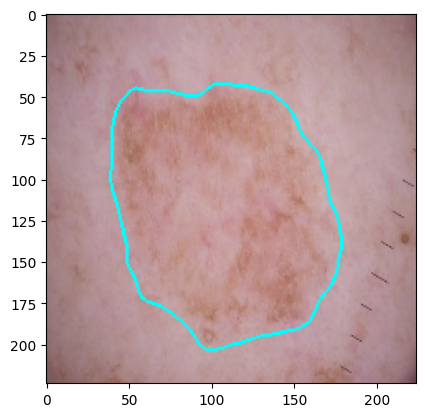

In [7]:
import matplotlib.pyplot as plt
plt.imshow(output)
plt.show()